## Retail Business Performance & Profitability Analysis
#### A retail company is facing increasing return rates, low profitability in certain product categories, and declining customer loyalty. This project aims to uncover the root causes of these issues through return analysis, customer segmentation using RFM, and identification of slow-moving products. The goal is to deliver actionable insights to improve marketing focus, inventory decisions, and strategic planning.

#### --- Import Libraries ---

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [25]:
import pandas as pd
from sqlalchemy import create_engine

#### --- Loading Data into SQL Database ---

###### ---- MySQL Configuration ----

In [51]:
user = "root"
password = "12345"   
host = "localhost"
database = "RETAIL_PROJECT"

###### ---- MySQL Connection via SQLAlchemy -----

In [53]:
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

###### ---- Load CSV Files with Encoding ----

In [80]:
orders = pd.read_csv(r'D:\Sample-Superstore-2022-CSV\Sample Superstore 2022 - Orders.csv', encoding='latin1', parse_dates=['Order Date', 'Ship Date'])
returned = pd.read_csv(r'D:\Sample-Superstore-2022-CSV\Sample Superstore 2022 - Returns.csv', encoding='latin1')
peoples = pd.read_csv(r'D:\Sample-Superstore-2022-CSV\Sample Superstore 2022 - People.csv', encoding='latin1')

###### ---- Clean Column Names for SQL Compatibility ----

In [ ]:
orders.columns = [col.strip().replace(" ", "_").replace("-", "_") for col in orders.columns]
Returns.columns = [col.strip().replace(" ", "_") for col in returns.columns]
People.columns = [col.strip().replace(" ", "_") for col in people.columns]

 ###### ---- Push DATA to MySQL -----

In [57]:
orders.to_sql('orders', con=engine, if_exists='replace', index=False)
returned.to_sql('returns', con=engine, if_exists='replace', index=False)
peoples.to_sql('people', con=engine, if_exists='replace', index=False)

4

###### ---- THIS IS SHOWING 4 BECAUSE ALREADY 1 TABLE IS PRESENT IN DATABASE -----

##  Now we will perform Data Cleaning, EDA, Logistic Regression, RFM, KMeans

#### --- Merge Tables ---

In [94]:
data = orders.merge(returned, on='Order ID', how='left')
data['Is_Returned'] = data['Order ID'].isin(returned['Order ID']).astype(int)
data = data.merge(peoples, on='Region', how='left')

In [149]:
data.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Sales,Quantity,Discount,Profit,Returned,Is_Returned,Regional Manager,Profit_Margin,Days_to_Ship,Days_to_Ship_Detail
0,1,US-2019-103800,2019-01-03,2019-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,16.448,2,0.2,5.5512,NaN,0,Roxanne Rodriguez,0.3375,4,4 days
1,2,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,3.540,2,0.8,-5.4870,NaN,0,Roxanne Rodriguez,-1.5500,4,4 days


#### --- Data Cleaning ---

In [105]:
data['Profit_Margin'] = data['Profit'] / data['Sales'].replace(0, np.nan)
data['Days_to_Ship'] = (data['Ship Date'] - data['Order Date']).dt.days

#### --- Drop rows with missing or negative values in key fields (including returned) ----

In [115]:
clean_data = data.dropna(subset=['Sales', 'Profit', 'Order Date', 'Ship Date', 'Returned'])
clean_data = clean_data[clean_data['Sales'] > 0]

#### --- Exploratory data analysis ---

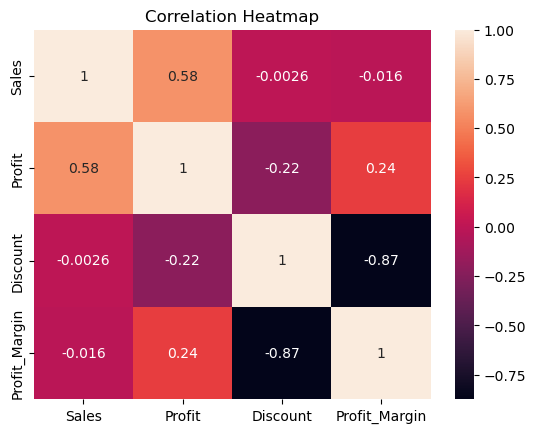

In [120]:
sns.heatmap(clean_data[['Sales', 'Profit', 'Discount', 'Profit_Margin']].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()

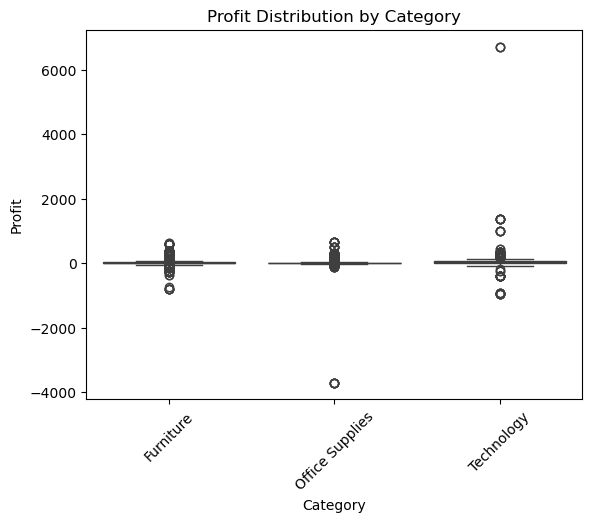

In [151]:
sns.boxplot(x='Category', y='Profit', data=clean_data)
plt.title("Profit Distribution by Category")
plt.xticks(rotation=45)
plt.show()

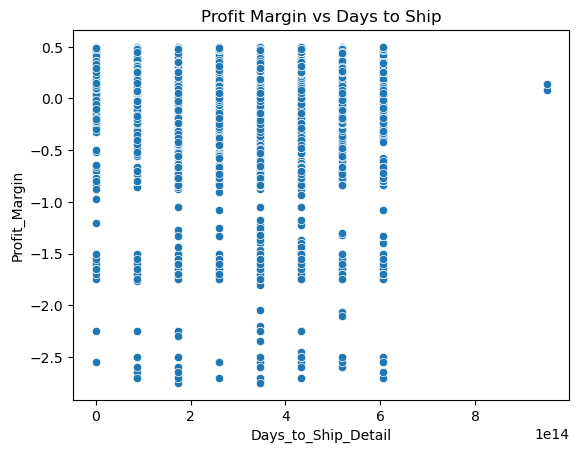

In [153]:
sns.scatterplot(x='Days_to_Ship_Detail', y='Profit_Margin', data=data)
plt.title("Profit Margin vs Days to Ship")
plt.show()

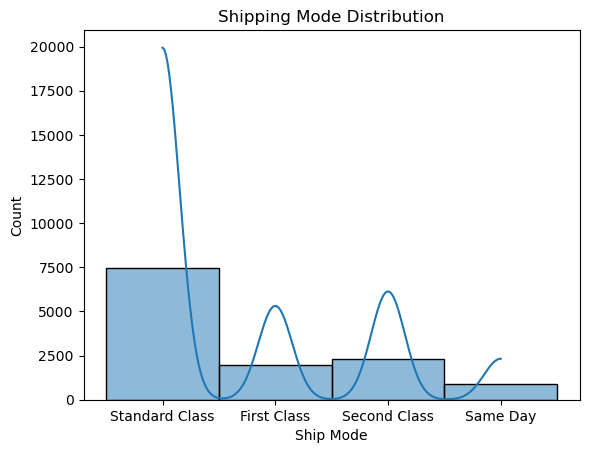

In [165]:
sns.histplot(data=data, x='Ship Mode', bins=15, kde=True)
plt.title("Shipping Mode Distribution")
plt.show()

##### --- Monthly Profit Trend ---

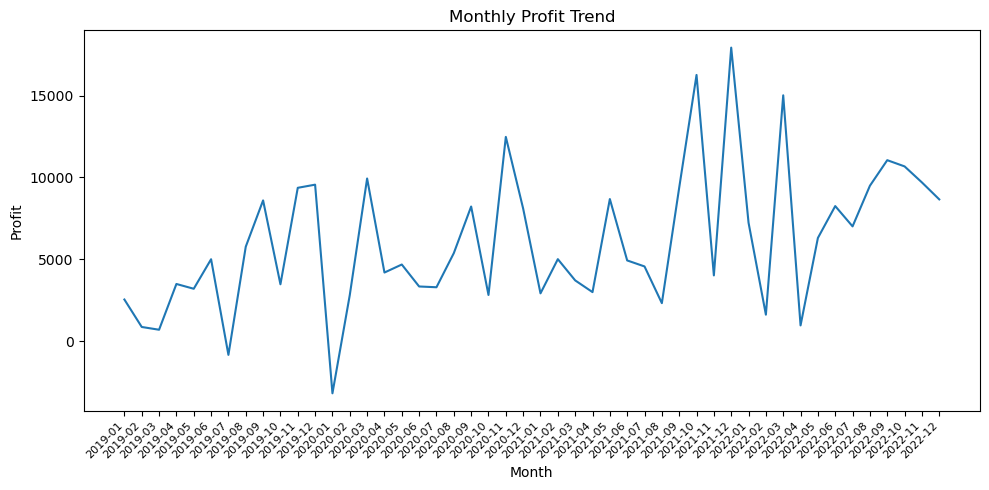

In [200]:
orders['Month'] = pd.to_datetime(orders['Order Date']).dt.to_period('M').astype(str)
monthly_profit = orders.groupby('Month')['Profit'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_profit, x='Month', y='Profit')
plt.title("Monthly Profit Trend")
plt.xticks(rotation=45, fontsize=8, ha='right')  # Ensures tick labels are readable
plt.tight_layout()
plt.show()


##### --- Basic Return Rate by Category ---

In [169]:
category_return = data.groupby('Category')['Is_Returned'].mean().reset_index()
print("\nReturn Rate by Category:\n", category_return)


Return Rate by Category:
           Category  Is_Returned
0        Furniture     0.248427
1  Office Supplies     0.253367
2       Technology     0.271215


##### --- RFM Scoring ---

In [173]:
latest = orders['Order Date'].max()
rfm = orders.groupby('Customer ID').agg({
    'Order Date': lambda x: (latest - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
}).reset_index()
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

rfm['RFM_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(str) + \
                   pd.qcut(rfm['Frequency'], 4, labels=[1,2,3,4]).astype(str) + \
                   pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(str)
print("\nRFM Sample:\n", rfm.head())



RFM Sample:
   Customer ID  Recency  Frequency  Monetary RFM_Score
0    AA-10315      184          5  5563.560       114
1    AA-10375       19          9  1056.390       441
2    AA-10480      259          4  1790.512       112
3    AA-10645       55          6  5086.935       324
4    AB-10015      415          3   886.156       111


##### --- Top Slow Moving Products ---

In [178]:
slow = data.groupby('Product ID').agg({
    'Days_to_Ship': 'mean',
    'Sales': 'sum',
    'Quantity': 'sum'
}).reset_index()
slow = slow[slow['Days_to_Ship'] > 5].sort_values(by='Sales')
print("\nSlow-Moving Products (High ship time, low sales):\n", slow.head())


Slow-Moving Products (High ship time, low sales):
            Product ID  Days_to_Ship   Sales  Quantity
606   OFF-AR-10003986      6.000000   7.700         2
978   OFF-LA-10002473      6.000000   9.216         4
1230  OFF-PA-10003739      6.000000  11.560         2
501   OFF-AR-10001022      5.666667  14.200         5
976   OFF-LA-10002368      6.000000  16.704         7


##### --- Label Slow-Moving Products -----

In [207]:
slow['Label'] = 'Slow Mover (Low Sales + High Ship Time)'
print("\nFlagged Slow-Movers:\n", slow[['Product ID', 'Sales', 'Days_to_Ship', 'Label']].head())



Flagged Slow-Movers:
            Product ID   Sales  Days_to_Ship  \
606   OFF-AR-10003986   7.700      6.000000   
978   OFF-LA-10002473   9.216      6.000000   
1230  OFF-PA-10003739  11.560      6.000000   
501   OFF-AR-10001022  14.200      5.666667   
976   OFF-LA-10002368  16.704      6.000000   

                                        Label  
606   Slow Mover (Low Sales + High Ship Time)  
978   Slow Mover (Low Sales + High Ship Time)  
1230  Slow Mover (Low Sales + High Ship Time)  
501   Slow Mover (Low Sales + High Ship Time)  
976   Slow Mover (Low Sales + High Ship Time)  


##### ---- Monthly Profit Trend -----

In [209]:
peak_month = monthly_profit.loc[monthly_profit['Profit'].idxmax()]
low_month = monthly_profit.loc[monthly_profit['Profit'].idxmin()]
print(f"\n📈 Peak Profit Month: {peak_month['Month']} → ₹{peak_month['Profit']:,.2f}")
print(f"📉 Lowest Profit Month: {low_month['Month']} → ₹{low_month['Profit']:,.2f}")



📈 Peak Profit Month: 2021-12 → ₹17,926.30
📉 Lowest Profit Month: 2020-01 → ₹-3,189.80


In [229]:
# Save the 'rfm' DataFrame as a CSV file to local storage in Jupyter Notebook
rfm.to_csv('D:/rfm_data.csv', index=False)

# Output the link to download the CSV file
import IPython.display as display
display.FileLink('D:/rfm_data.csv')


D:\rfm_data.csv